In [1]:
from modules.base import *

#### Parallelization

- 병렬작업

---

In [2]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, add]

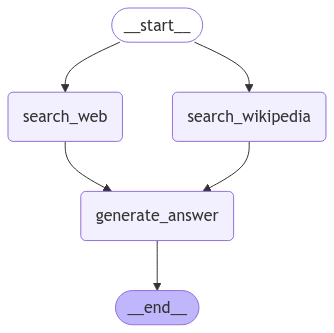

In [3]:
@trace_function(only_func_name=False, print_json_format=True)
def search_web(state):
    """
        Des:
            웹에서 데이터를 검색하여 컨텍스트 생성
    """
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]} 

@trace_function(only_func_name=False, print_json_format=True)
def search_wikipedia(state):
    """
        Des:
            위키피디아에서 데이터를 검색하여 컨텍스트 생성
    """
    search_docs = WikipediaLoader(query=state['question'], 
                                  load_max_docs=2).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]} 

@trace_function(only_func_name=False, print_json_format=True)
def generate_answer(state):
    """
        Des:
            질문에 대한 답변 생성
    """
    context = state["context"]
    question = state["question"]
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, context=context)    
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
    return {"answer": answer}

builder = StateGraph(State)
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
result = graph.invoke({"question": "How were Nvidia's Q2 2024 earnings"})
result['answer'].content


🚀 Passing Through [search_web] ..

#### [Input State]
args: [
    {
        "question": "How were Nvidia's Q2 2024 earnings",
        "context": []
    }
]

🚀 Passing Through [search_wikipedia] ..

#### [Input State]
args: [
    {
        "question": "How were Nvidia's Q2 2024 earnings",
        "context": []
    }
]

#### [Output State]
result: {
    "context": [
        "<Document href=\"https://www.cnbc.com/2023/08/23/nvidia-nvda-earnings-report-q2-2024.html\"/>\nBest Credit Cards Best Credit Cards for Small Business Best Small Business Loans Best Personal Loans for Bad Credit Nvidia's performance was driven by its data center business, which includes the A100 and H100 AI chips that are needed to build and run artificial intelligence applications like ChatGPT. Nvidia reported $10.32 billion in data center revenue, which was up 171% year over year. Nvidia's performance was driven by its data center business, which includes AI chips, as cloud service providers and large consumer inte

'Please provide the question you would like answered.'